# Small Example of iDLG on CIFAR10

In [3]:
from matplotlib import pyplot as plt 
import skimage 
import numpy as np 
from tqdm import tqdm
import torch as torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.optim.lbfgs import LBFGS
from PIL import Image
from torch.utils.data import DataLoader
from os import getcwd
from os.path import join

In [4]:
class iDLG:
    def __init__(
        self,
        model,
        orig_img,
        label,
        device,
        *,
        seed: int | None = None,
        clamp: tuple[float, float] | None = (0.0, 1.0),
    ) -> None:
        # Respect provided device and keep original dtype of the model/weights
        self.device = device if isinstance(device, str) else (device.type if hasattr(device, "type") else "cpu")
        self.model = model.to(self.device)
        self.orig_img = orig_img.to(self.device)
        self.criterion = nn.CrossEntropyLoss(reduction='sum').to(self.device)
        self.label = label.to(self.device)
        self.tt = transforms.ToPILImage()
        self.clamp = clamp

        # Align image dtype to model parameter dtype (usually float32)
        self.param_dtype = next(self.model.parameters()).dtype
        if self.orig_img.dtype != self.param_dtype:
            self.orig_img = self.orig_img.to(self.param_dtype)

        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

    def _infer_label_from_grads(self, orig_grads):
        # Map grads to names
        named_grads = {name: g for (name, _), g in zip(self.model.named_parameters(), orig_grads)}
        last_bias_name = None
        for name, param in self.model.named_parameters():
            if name.endswith(".bias") and param.ndim == 1:
                last_bias_name = name  # keep overwriting → last bias

        bias_grad = named_grads[last_bias_name]
        return torch.argmin(bias_grad).detach().reshape((1,))

    def attack(self, iterations=200):
        # iDLG training image reconstruction:
        self.model.eval()
        
        # compute original gradients
        predicted = self.model(self.orig_img)
        loss = self.criterion(predicted, self.label)
        orig_grads = torch.autograd.grad(loss, self.model.parameters())
        orig_grads = list((_.detach().clone() for _ in orig_grads))

        # initialize dummy in the correct iteration, respecting the random seed
        dummy_data = (torch.randn(self.orig_img.size(), dtype=self.param_dtype, device=self.device).requires_grad_(True))
        # dummy_data = torch.as_tensor(self.orig_img)

        # init with ground truth:
        label_pred = self._infer_label_from_grads(orig_grads).requires_grad_(False)
        optimizer = LBFGS(
            [dummy_data], lr=.1, max_iter=50,
            tolerance_grad=1e-09, tolerance_change=1e-11,
            history_size=100, line_search_fn='strong_wolfe'
        )

        history = []
        losses = []

        for iters in tqdm(range(iterations)):
            def closure():
                optimizer.zero_grad()
                dummy_pred = self.model(dummy_data)
                dummy_loss = self.criterion(dummy_pred, label_pred)
                dummy_dy_dx = torch.autograd.grad(dummy_loss, self.model.parameters(), create_graph=True)
                grad_diff = 0
                for gx, gy in zip(dummy_dy_dx, orig_grads):
                    grad_diff += ((gx - gy) ** 2).sum()
                grad_diff.backward()
                return grad_diff

            optimizer.step(closure)

            # Optional: keep dummy within valid input range
            if self.clamp is not None:
                with torch.no_grad():
                    dummy_data.clamp_(self.clamp[0], self.clamp[1])

            if iters % 1 == 0:
                current_loss = closure()
                losses.append(current_loss.item())
                history.append(self.tt(dummy_data[0].cpu()))

        return dummy_data.detach().numpy().squeeze(), label_pred, history, losses

### Define Model Architecture 

In [ ]:
# 1 x (conv + activation) -> linear to num_classes
class LeNetSimple1sig(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple1sig, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.randn(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

# Relu
class LeNetSimple1Relu(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple1Relu, self).__init__()
        act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.randn(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

In [ ]:
# 2 x (conv + activation) -> linear to num_classes
class LeNetSimple2sig(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple2sig, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.randn(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

# Relu
class LeNetSimple2Relu(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple2Relu, self).__init__()
        act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.randn(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

In [53]:
# 3 x conv + activation -> linear to num_classes
class LeNetSimple3sig(nn.Module):
    def __init__(self, channel: int = 3, hidden:int = 768, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple3sig, self).__init__()
        act = nn.Sigmoid
        self.layer1 = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),)
        self.layer2 = nn.Sequential(nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),)
        self.layer3 = nn.Sequential(nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),)
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(x)
        out = self.layer3(x)
        out = self.flatten(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

# Relu
class LeNetSimple3Relu(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple3Relu, self).__init__()
        act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.randn(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

model = LeNetSimple3sig()
model.layer_summary((1, 3, 32, 32))

Input shape: torch.Size([1, 3, 32, 32])
layer1 (Sequential) output shape:	 torch.Size([1, 12, 16, 16])
layer2 (Sequential) output shape:	 torch.Size([1, 12, 8, 8])
layer3 (Sequential) output shape:	 torch.Size([1, 12, 8, 8])
flatten (Flatten) output shape:	 torch.Size([1, 768])
fc (Sequential) output shape:	 torch.Size([1, 10])


In [51]:
# 3 x conv + activation +  -> linear 768 to 10

# Sigmoid
class LeNet3sigAvg(nn.Module):
    def __init__(self, channel: int = 3, hidden: int = 768, num_classes: int = 10):
        super(LeNet3sigAvg, self).__init__()
        act = nn.Sigmoid
        pool = nn.AvgPool2d(kernel_size=5, padding=5//2, stride=1)
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            pool,
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            pool,
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            pool,
            act(),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)
# Relu
class LeNetSimple3Relu(nn.Module):
    def __init__(self, channel: int = 3, hidden: int = 768, num_classes: int = 10):
        super(LeNetSimple3Relu, self).__init__()
        act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
model = LeNet3sigAvg()
model.layer_summary((1, 3, 32, 32))

Input shape: torch.Size([1, 3, 32, 32])
body (Sequential) output shape:	 torch.Size([1, 768])
Flattened shape: torch.Size([1, 768])
fc (Sequential) output shape:	 torch.Size([1, 10])


In [42]:
class LeNet(nn.Module):
    def __init__(self, channel: int = 3, hidden: int = 768, num_classes: int = 10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)

class LeNet5(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10):
        super(LeNet5, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(channel, 6, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
        )

        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.Sigmoid()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.flatten(x, 1)  # becomes (N, 120)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x
    
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)


### Initialize Model

In [35]:
# Define relevant variables for the ML task
batch_size = 100
num_classes = 10
learning_rate = 0.01
num_epochs = 1
modeltype = LeNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path = getcwd()

transform = transforms.Compose([transforms.ToTensor(),])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset,batch_size,shuffle=True)
testloader = DataLoader(testset,batch_size,shuffle=True)

model = modeltype().to(device)
cost = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(trainset)

save_dir = join(path, "reconstructions")
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):  
        images = images.to(device)
        labels = labels.to(device)
            
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
    if epoch == (num_epochs-1):
            torch.save(model.state_dict(), "grads_LeNet5test_sig_epoch_10.pt")

Epoch [1/1], Step [400/50000], Loss: 2.3005


In [29]:
model = LeNet5(num_classes=10)
checkpoint = torch.load("grads_LeNet5test_sig_epoch_10.pt", map_location="cpu")
print(type(checkpoint))
if isinstance(checkpoint, dict):
    print(checkpoint.keys())
model.load_state_dict(checkpoint if isinstance(checkpoint, dict) and all(isinstance(v, torch.Tensor) for v in checkpoint.values()) else checkpoint.get('model', checkpoint))
model.eval()

<class 'collections.OrderedDict'>
odict_keys(['layer1.0.weight', 'layer1.0.bias', 'layer2.0.weight', 'layer2.0.bias', 'layer3.0.weight', 'layer3.0.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


LeNet5(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
  )
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): Sigmoid()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

### Get a Datapoint 

In [36]:
# load an image from cifar10 from your dataloader 
input_image = torch.Tensor(np.transpose(skimage.io.imread("reconstructions/lenet_original_image.png") / 255, (2, 0, 1))[None, :, :, :])
label = torch.Tensor([1]).long() 

### Attack 

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:31<00:00, 31.51it/s]


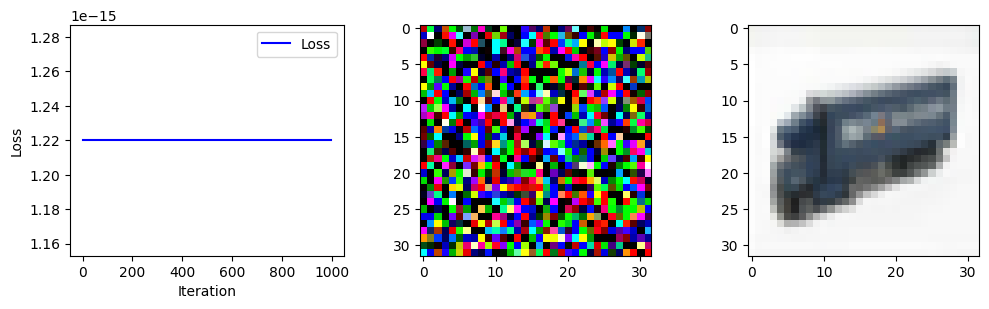

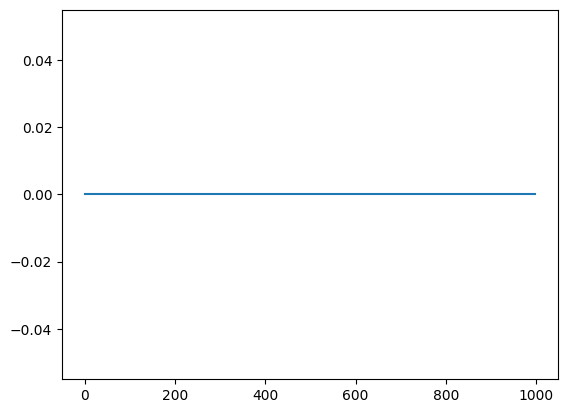

In [31]:
idlg = iDLG(model=model, device=torch.device("cpu"), orig_img = input_image, label = torch.tensor([label.item()]), clamp = (0, 1))
dummy_data_idlg, label_pred_idlg, history_idlg, losses_idlg = idlg.attack(iterations=1000)

fig, ax = plt.subplots(1, 3, figsize = (12, 3))
ax[0].plot(losses_idlg, 'b-', label = 'Loss')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].imshow(np.transpose(dummy_data_idlg, (1, 2, 0)))
# Show the original input image correctly
ax[2].imshow(np.transpose(input_image.squeeze().numpy(), (1, 2, 0)))
# ax[1].imshow(history_invgra[34])
plt.show()

diff = [(np.array(history_idlg[i+1]) - np.array(history_idlg[i])).sum().item() for i in range(len(history_idlg)-1)]
plt.plot(diff)
plt.show()

